In [23]:
#========
#OVERVIEW
#========

#This Script removes visualizations and focuses on the ninth [9th] of many Hyperparameter Tuning.  
# RandomizedSearchCV is used for tuning.

# Define the hyperparameters to tune
param_dist = {
    'units': [60, 70, 80],             # More units can capture more complex patterns but may lead to overfitting. Fewer units may result in underfitting.
    'optimizer': ['adam'],         # Different optimizers have different convergence properties and can affect training speed and stability.
    'epochs': [15, 20],                 # The number of times the entire dataset is passed forward and backward through the neural network.
    'dropout_rate': [0.02, 0.03],  # A higher dropout rate reduces overfitting but may also reduce the model's ability to learn complex patterns.
    'batch_size': [5, 10]          # Smaller batch sizes can lead to better generalization, but may increase training time.  Larger batch sizes can speed up training
}

#========
# EVALUATION & VALIDATION
#========
#RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1)
#Best parameters found:  {'units': 60, 'optimizer': 'adam', 'epochs': 20, 'dropout_rate': 0.02, 'batch_size': 5}
#Total time for hyperparameter tuning: 90.75 minutes
#Mean Absolute Error: 2.77325386168637
#Mean Squared Error: 12.19916227303069

# NOTE:  These are the best results so far via hypertuning and it is costly at 90 minutes of computing.  The more epochs, the more accurate the model results. 

In [22]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# To suppress all warnings, use
# warnings.filterwarnings('ignore')


In [24]:
# !pip install --upgrade keras

# done 2024-12-06

In [25]:
#pip install --upgrade h5py

# # done 2024-12-06

In [26]:
# !pip install scikeras

# # done 2024-12-06

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

import time # to track time for hyperparamater tuning
import datetime
from scikeras.wrappers import KerasRegressor
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

print('done')

done


In [28]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print('done')

done


In [29]:
stock_data = pd.read_csv('datasets/merged_stock_data.csv')

#Mag 7 list
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'META', 'TSLA', 'NVDA']
#company_list = [AAPL, GOOG, MSFT, AMZN, META, TSLA, NVDA]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "META", "TESLA", "NVIDIA"]


stock_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,company_name,20EMA,50SMA,RSI,VIX
0,2012-03-14,20.64,21.24,20.55,21.06,17.78,1418844000,AAPL,19.04,17.15,85.52,15.31
1,2012-03-15,21.41,21.43,20.66,20.91,17.66,1159718000,AAPL,19.21,17.27,81.25,15.42
2,2012-03-16,20.88,21.04,20.64,20.91,17.66,825487600,AAPL,19.38,17.39,80.61,14.47
3,2012-03-19,21.37,21.49,21.04,21.47,18.13,901236000,AAPL,19.58,17.52,81.71,15.04
4,2012-03-20,21.41,21.67,21.12,21.64,18.28,816662000,AAPL,19.77,17.65,81.32,15.58


In [30]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume,20EMA,50SMA,RSI,VIX
count,22142.000000,22142.000000,22142.000000,22142.000000,22142.000000,2.214200e+04,22142.000000,22142.000000,22142.000000,22142.000000
mean,94.148975,95.344914,92.929938,94.173105,92.969392,1.305048e+08,93.381725,92.152364,54.868988,17.596528
std,99.330652,100.601410,98.013235,99.336681,99.070509,1.807211e+08,98.337136,96.999821,16.743461,6.735919
min,0.290000,0.290000,0.280000,0.280000,0.260000,1.584340e+05,0.300000,0.300000,3.140000,9.140000
25%,20.130000,20.420000,19.850000,20.150000,19.430000,2.900450e+07,20.080000,19.902500,42.760000,13.250000
50%,52.350000,52.935000,51.690000,52.260000,50.335000,6.106800e+07,51.785000,51.025000,55.060000,15.760000
75%,146.142500,147.997500,144.507500,146.397500,144.937500,1.360277e+08,145.667500,144.227500,67.247500,20.030000
max,598.220000,602.950000,589.960000,595.940000,595.940000,3.692928e+09,575.000000,552.220000,99.430000,82.690000


In [31]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22142 entries, 0 to 22141
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          22142 non-null  datetime64[ns]
 1   Open          22142 non-null  float64       
 2   High          22142 non-null  float64       
 3   Low           22142 non-null  float64       
 4   Close         22142 non-null  float64       
 5   Adj Close     22142 non-null  float64       
 6   Volume        22142 non-null  int64         
 7   company_name  22142 non-null  object        
 8   20EMA         22142 non-null  float64       
 9   50SMA         22142 non-null  float64       
 10  RSI           22142 non-null  float64       
 11  VIX           22142 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 2.0+ MB


In [32]:
stock_data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,company_name,20EMA,50SMA,RSI,VIX
0,2012-03-14,20.64,21.24,20.55,21.06,17.78,1418844000,AAPL,19.04,17.15,85.52,15.31
1,2012-03-15,21.41,21.43,20.66,20.91,17.66,1159718000,AAPL,19.21,17.27,81.25,15.42


In [33]:
company_counts = stock_data.groupby('company_name').size().reset_index(name='counts')

print(company_counts)

  company_name  counts
0         AAPL    3176
1         AMZN    3177
2         GOOG    3177
3         META    3082
4         MSFT    3176
5         NVDA    3177
6         TSLA    3177


In [34]:
#plotting the distribution
def plot_adj_close_boxplot(data_fs):
    num_cols = data_fs['company_name'].unique()  # Get unique tickers
    
    fig = make_subplots(rows=1, cols=len(num_cols), 
                        subplot_titles=num_cols, 
                        vertical_spacing=0.2)

    for i, ticker in enumerate(num_cols):
        fig.add_trace(go.Box(y=data_fs[data_fs['company_name'] == ticker]['Adj Close'], 
                             name=ticker), row=1, col=i+1)

    fig.update_layout(height=400, width=1200, showlegend=False, 
                      title_text=f'Box Plots of Adj Close Prices')
    
    fig.show()


plot_adj_close_boxplot(stock_data)

In [35]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()

# Create a pivot table for Adjusted Close prices
adj_close_matrix = stock_data.pivot(index='Date', columns='company_name', values='Adj Close')

# Calculate the correlation matrix for Adj Close
adj_close_corr = adj_close_matrix.corr()

# Create a pivot table for Daily Returns
daily_return_matrix = stock_data.pivot(index='Date', columns='company_name', values='Daily Return')

# Calculate the correlation matrix for Daily Returns
daily_return_corr = daily_return_matrix.corr()

print('done')

done


In [36]:
apple_data = stock_data[stock_data['company_name'] == 'AAPL']  # Replace 'AAPL' with Apple ticker if different
apple_data = apple_data.dropna()
apple_data["Date"] = pd.to_datetime(apple_data["Date"])
apple_data = apple_data.sort_values("Date").reset_index(drop=True)

apple_data.head(2)


,Date,Open,High,Low,Close,Adj Close,Volume,company_name,20EMA,50SMA,RSI,VIX,Daily Return
0,2012-03-15,21.41,21.43,20.66,20.91,17.66,1159718000,AAPL,19.21,17.27,81.25,15.42,-0.006749
1,2012-03-16,20.88,21.04,20.64,20.91,17.66,825487600,AAPL,19.38,17.39,80.61,14.47,0.000000


In [37]:
data = apple_data.filter(['Adj Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

3017

In [38]:
features = ["Adj Close", "Volume", "20EMA", "50SMA", "RSI", "VIX", "Daily Return"]
data_values = apple_data[features].values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0254309 ],
       [0.0254309 ],
       [0.02752416],
       ...,
       [0.97452456],
       [0.97367835],
       [0.9774195 ]])

In [39]:
# Prepping the data for LSTM Model

sequence_length = 120
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])  # Append previous `sequence_length` days
    y.append(scaled_data[i, 0])  # The next day's Close price

X, y = np.array(X), np.array(y)

X.shape, y.shape

((3055, 120, 1), (3055,))

In [40]:
# ===================================================================

# this is where things change to optimize model performance through hyperparameter tuning and use GridSearchCV or RandomizedSearchCV for tuning.

# ===================================================================

In [41]:
# Split the data
train_size = int(len(scaled_data) * 0.8)  # 80% for training
X_train, X_val, y_train, y_val = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Define a function to create the model, required for KerasRegressor
def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),  # was 25
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, units=50, dropout_rate=0.2, optimizer='adam', verbose=1)

# Define the hyperparameters to tune
param_dist = {
    'units': [60, 70, 80],             # More units can capture more complex patterns but may lead to overfitting. Fewer units may result in underfitting.
    'optimizer': ['adam'],         # Different optimizers have different convergence properties and can affect training speed and stability.
    'epochs': [15, 20],                 # The number of times the entire dataset is passed forward and backward through the neural network.
    'dropout_rate': [0.02, 0.03],  # A higher dropout rate reduces overfitting but may also reduce the model's ability to learn complex patterns.
    'batch_size': [5, 10]          # Smaller batch sizes can lead to better generalization, but may increase training time.  Larger batch sizes can speed up training
}

# Start the timer
start_time = time.time()

# Get the current date and time
now = datetime.datetime.now()
print("Current date and time:")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

print('done')

Current date and time:
2024-12-07 18:53:37
done


In [42]:
# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1)
random_search_result = random_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found: ", random_search_result.best_params_)

# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = (end_time - start_time) /60
print(f"Total time for hyperparameter tuning: {elapsed_time:.2f} minutes")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0088
Epoch 2/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 5.7799e-04
Epoch 3/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 4.5124e-04
Epoch 4/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 4.5350e-04
Epoch 5/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 3.6427e-04
Epoch 6/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 3.1720e-04
Epoch 7/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 3.5589e-04
Epoch 8/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 2.5663e-04
Epoch 9/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 2.8301e-04
Epoch 10/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 3.0786e-04
Epoch 11/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 2.1264e-04
Epoch 12/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 2.4326e-04
Epoch 13/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 1

In [43]:
# Train the final model with the best parameters
best_params = random_search_result.best_params_
final_model = create_model(units=best_params['units'], dropout_rate=best_params['dropout_rate'], optimizer=best_params['optimizer'])
final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Prepare test data
test_data = scaled_data[train_size - sequence_length:, :]

X_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i - sequence_length:i])
    y_test.append(test_data[i, 0])  # Assuming first column is Close price

X_test, y_test = np.array(X_test), np.array(y_test)

# Make predictions
predictions = final_model.predict(X_test)

# Reverse scaling to get actual prices
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Evaluate predictions
print("Mean Absolute Error:", mean_absolute_error(y_test_actual, predictions))
print("Mean Squared Error:", mean_squared_error(y_test_actual, predictions))

Epoch 1/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.0049
Epoch 2/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 3.5763e-04
Epoch 3/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 3.5891e-04
Epoch 4/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 3.4291e-04
Epoch 5/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 2.3192e-04
Epoch 6/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 2.0839e-04
Epoch 7/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 2.0606e-04
Epoch 8/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 1.6018e-04
Epoch 9/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 1.6461e-04
Epoch 10/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 1.8335e-04
Epoch 11/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 1.8174e-04
Epoch 12/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.8898e-04
Epoch 13/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.8218e-04
Epoch 14/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/s

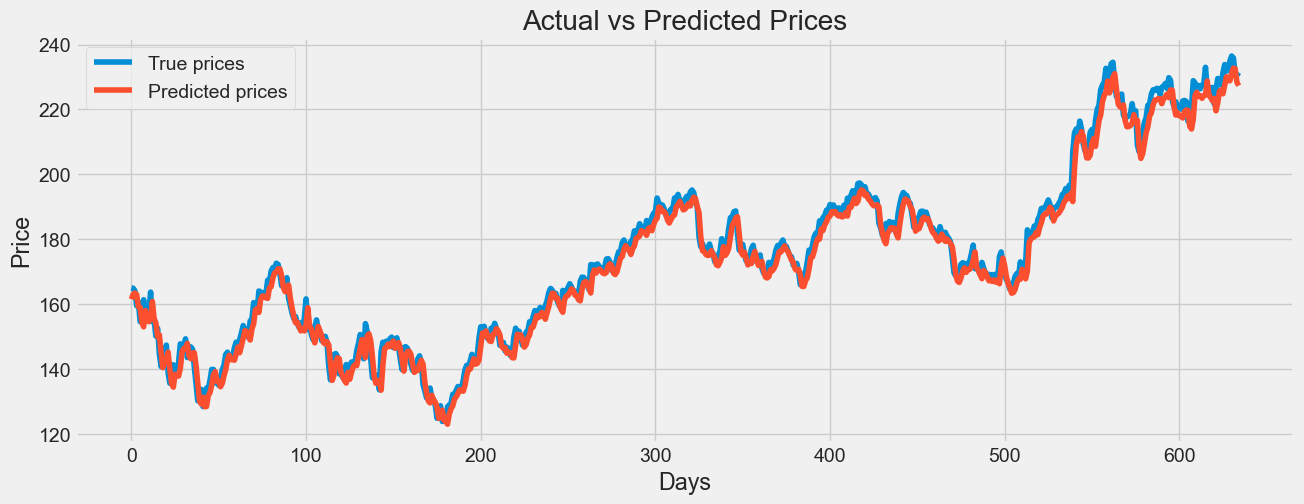

In [44]:
# Plotting the results
plt.figure(figsize=(14,5))
plt.plot(y_test_actual, label='True prices')
plt.plot(predictions, label='Predicted prices')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()